In [243]:
import warnings
import os
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch import nn
from torch.nn import functional as F
from torchvision import models
from torchvision.models.resnet import conv3x3, BasicBlock
import random
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from datetime import datetime
from os import listdir
from os.path import join
import cv2
import matplotlib.pyplot as plt
import math
from tqdm import tqdm_notebook, tqdm
import ast
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from skimage.feature import greycomatrix, greycoprops
from scipy.stats import moment
from functools  import partial
import json
# import pydicom as dicom
from pydicom.filereader import read_dicomdir
from pydicom.data import get_testdata_files
import dicom_contour.contour as dcm

from dicom_contour.contour import *

In [244]:
PATH = Path('/home/schen145/dl/medomics')
data_path = PATH/'data'
studies_dirs = [os.path.join(data_path,study) for study in os.listdir(data_path)]

In [245]:
def get_pair_dirs(studies_dirs):
    cases=[]
    files = []
    rtst_mr_pair = {}
    for study in studies_dirs:
        case = [os.path.join(study,case) for case in os.listdir(study)]
        cases+=case
    info_array = np.array([[i,'_'.join(case.split('_')[2:4]),case.split('_')[4]] for i,case in enumerate(cases)])
    unique_id = np.unique([info[1] for info in info_array])
    dic = {}
    for id in unique_id:
        path_image = info_array[info_array[:,1]==id]
        path_index = path_image[path_image[:,2]=='RTst'][:,0][0].astype(int)
        image_index = path_image[path_image[:,2]=='MR'][:,0][0].astype(int)
        dic.update({path_index:image_index})
    for item in dic.items():
        rtst_mr_pair.update({cases[item[0]]:cases[item[1]]})
    return rtst_mr_pair
        
        

In [246]:
def get_contour_file(path):
    """
    Get contour file from a given path by searching for ROIContourSequence 
    inside dicom data structure.
    More information on ROIContourSequence available here:
    http://dicom.nema.org/medical/dicom/2016c/output/chtml/part03/sect_C.8.8.6.html
    
    Inputs:
            path (str): path of the the directory that has DICOM files in it, e.g. folder of a single patient
    Return:
        contour_file (str): name of the file with the contour
    """
    # handle `/` missing
    if path[-1] != '/': path += '/'
    # get .dcm contour file
    fpaths = [path + f for f in os.listdir(path) if '.dcm' in f]
    n = 0
    for fpath in fpaths:
        f = dicom.read_file(fpath)
        if 'ROIContourSequence' in dir(f):
            contour_file = fpath.split('/')[-1]
            n += 1
    if n > 1: warnings.warn("There are multiple files, returning the last one!")
    return contour_file

In [247]:
def cfile2pixels(file, image_path, rt_path, ROIContourSeq=1):
    """
    Given a contour file and path of related images return pixel arrays for contours
    and their corresponding images.
    Inputs
        file: filename of contour
        path: path that has contour and image files
        ROIContourSeq: tells which sequence of contouring to use default 0 (RTV)
    Return
        contour_iamge_arrays: A list which have pairs of img_arr and contour_arr for a given contour file
    """
    # handle `/` missing
    if rt_path[-1] != '/': rt_path += '/'
    if image_path[-1] != '/': image_path += '/'
    f = dicom.read_file(rt_path + file)
    # target index means the information we are getting
    target = f.ROIContourSequence[ROIContourSeq]
    # get contour datasets in a list
    contours = [contour for contour in target.ContourSequence]
    img_contour_arrays = [coord2pixels(cdata, image_path) for cdata in contours]
    return img_contour_arrays

In [248]:
rtst_mr_pairs = get_pair_dirs(studies_dirs)

In [249]:
for pair in rtst_mr_pair.items():
    rt_path = pair[0]
    image_path = pair[1]

In [250]:
contour_file = get_contour_file(rt_path)
contour_data = dicom.read_file(rt_path + '/' + contour_file)

In [251]:
get_roi_names(contour_data)

['target2',
 'target3',
 'target4',
 'target5',
 'target6',
 '*Skull',
 'Brain',
 'Ventricles']

In [252]:
list_of_pairs = cfile2pixels(contour_file,image_path,rt_path)

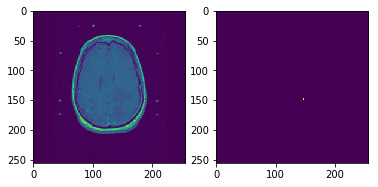

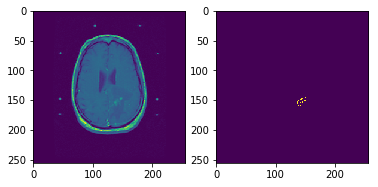

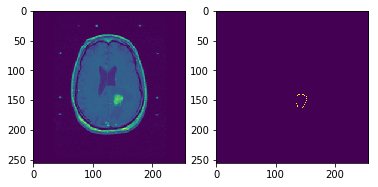

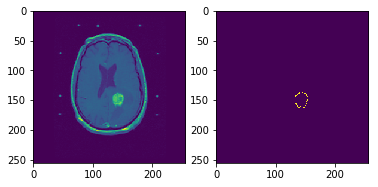

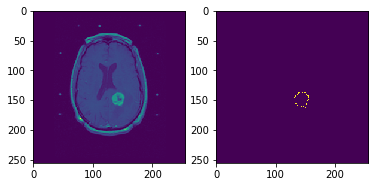

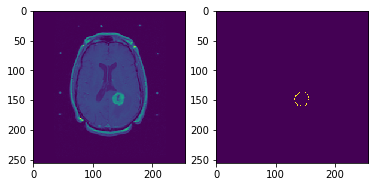

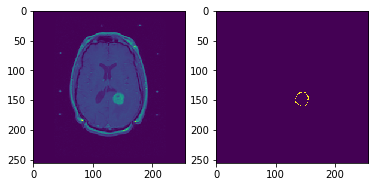

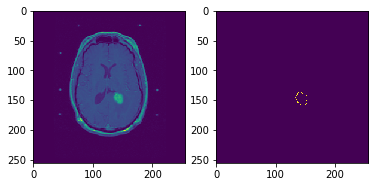

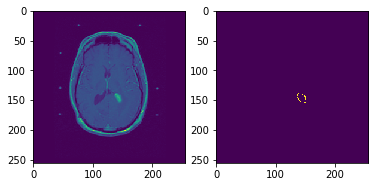

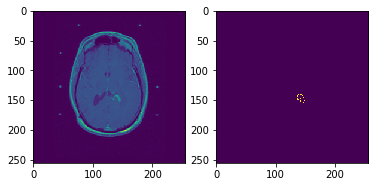

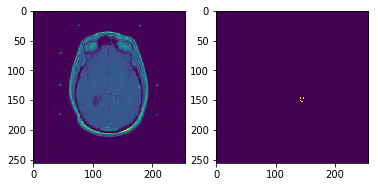

In [254]:
for pair in list_of_pairs:
#     print(pair[2])
    fig,axs = plt.subplots(1,2)
    ax1 = axs[0]
    ax2 = axs[1]
    ax1.imshow(pair[0])
    ax2.imshow(pair[1])